# Comparing theoretical and observed performance in solar arrays

implementations the pvlib package to explore:
    * Calcualted position of the sun
    * Total irradiance incident on a titled / non zero azimuth  fixed panel

In [1]:
import pandas as pd

## Import data

In [2]:
raw_data = pd.read_csv('Alice_Springs_2018.csv')

In [4]:
from pvlib.solarposition import get_solarposition

import datetime

In [17]:
def proccess_annual_data(data):
    data.index=pd.to_datetime(data.Timestamp)
    cols = list(data.columns)
    power_cols = [s for s in cols if 'Active Power' in s and s[0].isdigit()]
    weather_cols = [s for s in cols if 'WeatherStation' in s]
    
    select_cols = power_cols + weather_cols
    
    new_power_cols = [s.split(' ')[0] for s in power_cols]
    new_weather_cols = [s.replace('DKA.WeatherStation - ',"") for s in weather_cols]
    
    new_cols = new_power_cols + new_weather_cols
    
    power_data = data[select_cols].fillna('0')
    power_data.columns = new_cols
    power_data=power_data.astype(float)
    
    return power_data, new_power_cols, new_weather_cols

def norm_av_df(df):
    # creats normalised average daily patterns for time series data
    
    df_av = df.groupby(df.index.hour).mean()  # average value for each hour of the day
    
    df_av_norm = (df_av-df_av.min())/(df_av.max()-df_av.min()) # normalise the data set for comparative analysis
    
    return df_av, df_av_norm



In [18]:
# read and localise observed time series data
data, power_cols, weather_cols = proccess_annual_data(raw_data)


In [19]:
# localize the timestamp data: error handling required, investigate further
data.index = data.index.tz_localize('Australia/South',ambiguous = "NaT",nonexistent="NaT")
data = data[~data.index.duplicated()]  

In [20]:
# calculate average and normalised curves for observed data
data_av , data_av_norm = norm_av_df(data)

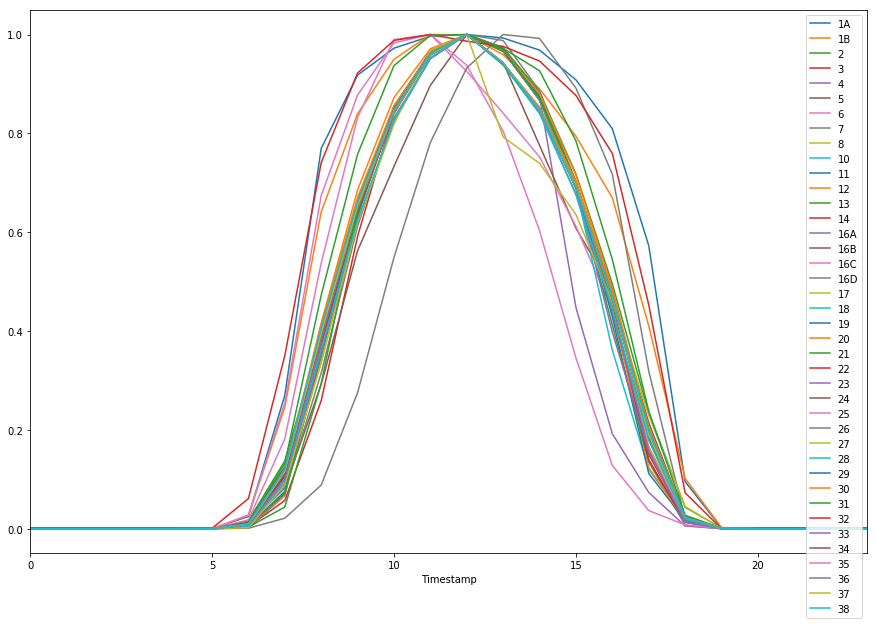

In [25]:
data_av_norm[power_cols].plot(figsize = (15,10), title = )

In [106]:
from pvlib.location import Location

#Desert Knowledge Australia Solar Centre (DKASC) 
# Creat a location object
DKASC = Location(23.7618, 133.8749, 'Australia/South', 583,'DKASC')
print(DKASC)




In [205]:

#times_loc = times.tz_localize(DKASC.pytz,ambiguous = "NaT",nonexistent="NaT") #check these error handles later

2018-05-05 23:55:00+09:30
2018-05-05 23:55:00+09:30


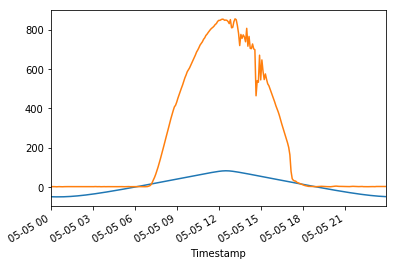

In [207]:

times_au = data.index
spaout_australia = pvlib.solarposition.spa_python(times_au, DKASC.latitude, DKASC.longitude)
spaout_australia.loc['2018-05-05','elevation'].plot()
data.loc['2018-05-05','Global Horizontal Radiation (W/m²)'].plot()

x1=data.loc['2018-05-05','Global Horizontal Radiation (W/m²)'].index.max()
x2 = spaout_australia.loc['2018-05-05','elevation'].index.max()


print(x1)
print(x2)


In [208]:
# Next we need to decompose the radiation into its constituent components

from pvlib.irradiance import dni 
#https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.dni.html#pvlib.irradiance.dni

GHI = data['Global Horizontal Radiation (W/m²)']
DHI = data['Diffuse Horizontal Radiation (W/m²)']
zenith = spaout_australia['zenith']

DNI= dni(GHI,DHI,zenith)
DNI = DNI.fillna(0)

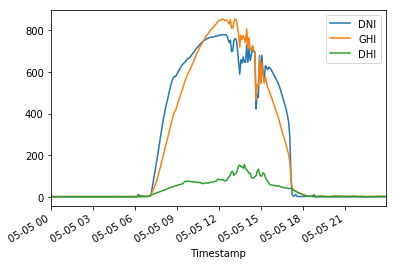

In [225]:
#examine outputs for given date
date = '2018-05-05'


DNI[date].plot(label='DNI', legend=True)
DNI = DNI.fillna(0)
GHI[date].plot(label='GHI', legend=True)
DHI[date].plot(label='DHI', legend=True)


https://www.quora.com/Can-global-irradiation-be-less-than-direct-normal-irradiation

In [179]:
# lets now try modelling the radiation incident on the solar pannels
from pvlib.irradiance import get_total_irradiance
solar_azimuth = spaout_australia['azimuth']
solar_zenith = spaout_australia['zenith']
surface_tilt = 20
surface_azimuth = 270

#calculate for 16D azimuth of 270 degrees
sixteenD_irr = get_total_irradiance(surface_tilt,270,solar_zenith,solar_azimuth,DNI,GHI,DHI)
sixteenD_irr_av = average_df(sixteenD_total_irr)
sixteenD_irr_av_norm = normalise_df(sixteenD_irr_av)

#calculate for 16D azimuth of 90 degrees
sixteenC_irr = get_total_irradiance(surface_tilt,90,solar_zenith,solar_azimuth,DNI,GHI,DHI)
sixteenC_irr_av = average_df(sixteenC_irr)
sixteenC_irr_av_norm = normalise_df(sixteenC_irr_av)

#calculate for other fixed panels with zero azimuth
others_irr = get_total_irradiance(surface_tilt,0,solar_zenith,solar_azimuth,DNI,GHI,DHI)
others_irr_av = average_df(others_irr)
others_irr_av_norm = normalise_df(others_irr_av)



,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
Timestamp,,,,,,
2018-01-01 00:00:00+10:30,157.619785,157.619785,-67.619785,-67.619785,266.873319,-3.119703
2018-01-01 00:05:00+10:30,158.761852,158.761852,-68.761852,-68.761852,267.230566,-3.121347
2018-01-01 00:10:00+10:30,159.904267,159.904267,-69.904267,-69.904267,267.598062,-3.122992
2018-01-01 00:15:00+10:30,161.046995,161.046995,-71.046995,-71.046995,267.977894,-3.124637
2018-01-01 00:20:00+10:30,162.189996,162.189996,-72.189996,-72.189996,268.372669,-3.126281


In [274]:
#surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni, ghi, dhi,

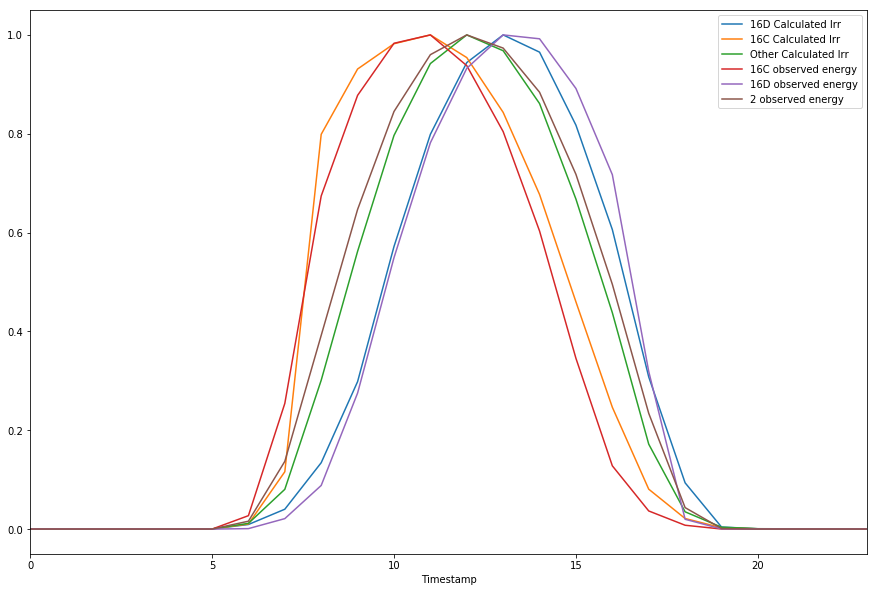

In [278]:

date = '2018-09-08'

sixteenD_irr_av_norm.poa_global.plot(label='16D Calculated Irr', legend= True, figsize = (15,10))

sixteenC_irr_av_norm.poa_global.plot(label='16C Calculated Irr', legend= True)


others_irr_av_norm.poa_global.plot(label='Other Calculated Irr', legend= True)

pv_data_av_norm['16C'].plot(label='16C observed energy', legend= True)

pv_data_av_norm['16D'].plot(label='16D observed energy', legend= True)

pv_data_av_norm['2'].plot(label='2 observed energy', legend= True)


#pv_data_averages_normed['16D'].plot()


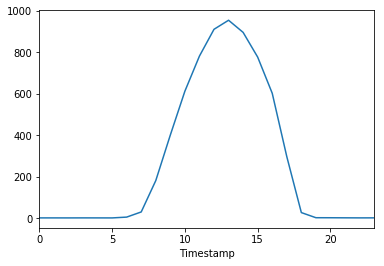

In [248]:
irradience_average = total_irr['2018-09'].groupby(total_irr['2018-09'].index.hour).mean()
irradience_average['poa_global'].plot()